<a href="https://colab.research.google.com/github/jessjohn1539/TE_mini_project/blob/main/Efficientnet_lung_cancer_model_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code contains the model.
It contains the training output with 25 epochs.

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers


SEED = 15243
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)

plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif")

In [ ]:
BATCH_SIZE = 25
DATA_DIR = ("archive/"
            "lung_colon_image_set/lung_image_sets")
IMG_SIZE = 256
MAX_EPOCHS = 25
class_names = ["lung_n", "lung_aca", "lung_scc"]
class_details = ["No Cancer", "Adenocarcinoma", "Squamous Cell Carcinoma"]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    subset="training",
    validation_split=0.3
)
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    subset="validation",
    validation_split=0.2
)

Found 15000 files belonging to 3 classes.
Using 10500 files for training.
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.


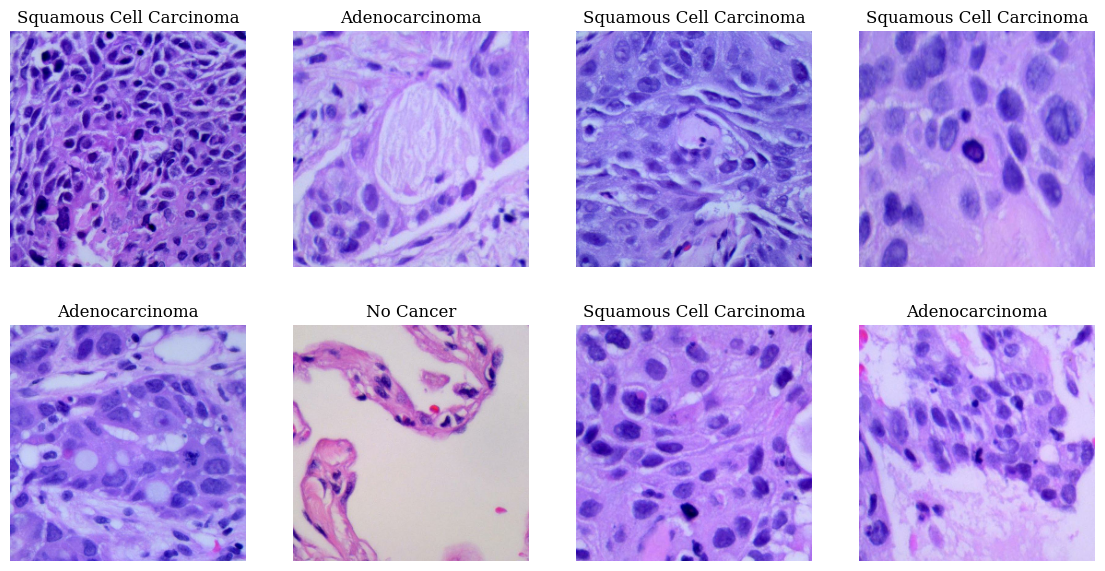

In [ ]:
plt.figure(figsize=(14, 7))
for images, labels in train_ds.take(1):
    labels = labels.numpy()
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_details[labels[i]])
        plt.axis("off")

In [ ]:
# Cache and prefetch data for faster training
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache(".cached-data").prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)


def compile_and_fit_model(model: tf.keras.Sequential) -> tf.keras.callbacks.History:
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        min_lr=0.001
    )
    history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=MAX_EPOCHS,
        callbacks=[reduce_lr]
    )
    performance_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for ax, metric in zip(axes.flat, ["accuracy", "loss"]):
        performance_df.filter(like=metric).plot(ax=ax)
        ax.set_title(metric.title(), size=15, pad=20)
    return history


def plot_predictions(model: tf.keras.Sequential) -> None:
    plt.figure(figsize=(14, 14))
    for images, labels in train_ds.take(1):
        labels = labels.numpy()
        predicted_labels = np.argmax(model.predict(images), axis=1)
        for i, (actual, pred) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if actual == pred:
                plt.title(class_details[labels[i]], color="green", size=9)
            else:
                plt.title(f"{class_details[predicted_labels[i]]}\n"
                          + f"(Actual: {class_details[labels[i]]})",
                          color="red", size=9)
            plt.axis("off")

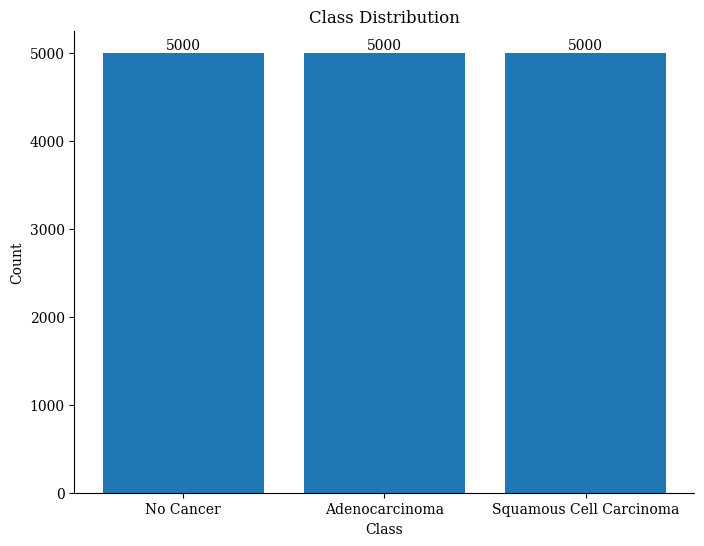

In [ ]:
class_counts = []
for class_name in class_names:
    class_dir = os.path.join(DATA_DIR, class_name)
    num_images = len(os.listdir(class_dir))
    class_counts.append(num_images)

plt.figure(figsize=(8, 6))
barplot = plt.bar(class_details, class_counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")

# Add count labels on top of the bars
for i, count in enumerate(class_counts):
    plt.text(i, count, str(count), ha="center", va="bottom")

plt.show()

In [ ]:
prerained_efficientnet_base = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False, weights="imagenet", pooling="avg",
)
prerained_efficientnet_base.trainable = False

efficientnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    prerained_efficientnet_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 1280)             6575239   
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 6,739,594
Trainable params: 164,355
Non-trainable params: 6,575,239
_________________________________________________________________


Epoch 1/25
420/420 [==============================] - 918s 2s/step - loss: 0.1151 - accuracy: 0.9552 - val_loss: 0.0444 - val_accuracy: 0.9823 - lr: 0.0010
Epoch 2/25
420/420 [==============================] - 852s 2s/step - loss: 0.0525 - accuracy: 0.9799 - val_loss: 0.0275 - val_accuracy: 0.9917 - lr: 0.0010
Epoch 3/25
420/420 [==============================] - 822s 2s/step - loss: 0.0342 - accuracy: 0.9864 - val_loss: 0.0156 - val_accuracy: 0.9950 - lr: 0.0010
Epoch 4/25
420/420 [==============================] - 835s 2s/step - loss: 0.0253 - accuracy: 0.9913 - val_loss: 0.0237 - val_accuracy: 0.9910 - lr: 0.0010
Epoch 5/25
420/420 [==============================] - 865s 2s/step - loss: 0.0297 - accuracy: 0.9879 - val_loss: 0.0110 - val_accuracy: 0.9967 - lr: 0.0010
Epoch 6/25
420/420 [==============================] - 845s 2s/step - loss: 0.0230 - accuracy: 0.9922 - val_loss: 0.0079 - val_accuracy: 0.9977 - lr: 0.0010
Epoch 7/25
420/420 [==============================] - 1363s 3s/s

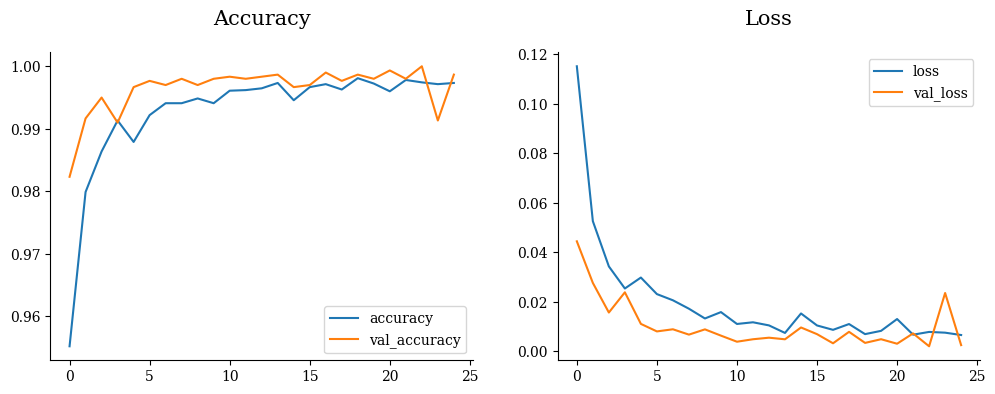

In [ ]:
efficientnet_history = compile_and_fit_model(efficientnet_model)

1/1 [==============================] - 5s 5s/step


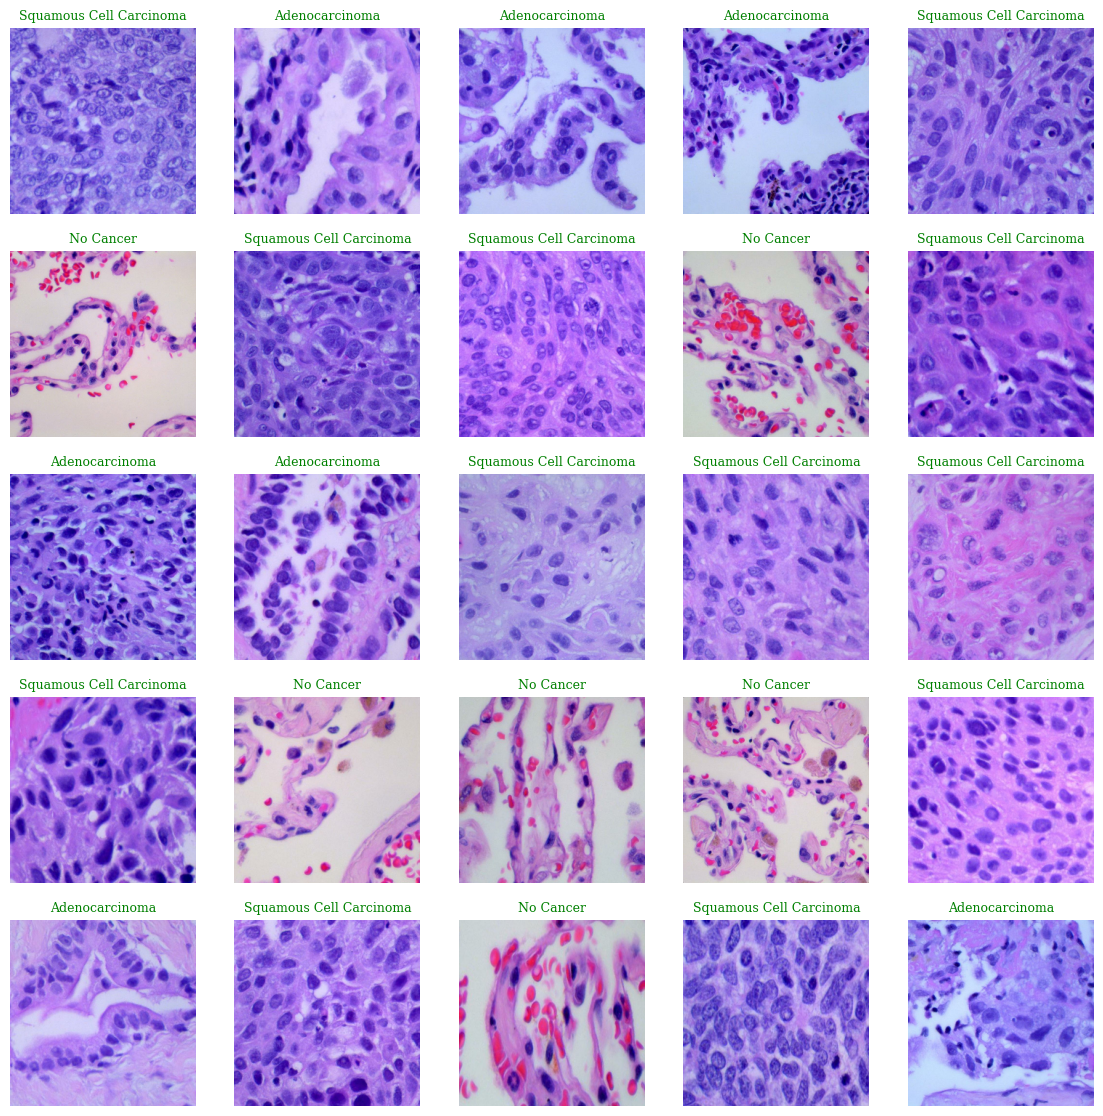

In [ ]:
plot_predictions(efficientnet_model)

Found 15000 files belonging to 3 classes.
Using 3000 files for validation.
120/120 [==============================] - 179s 1s/step


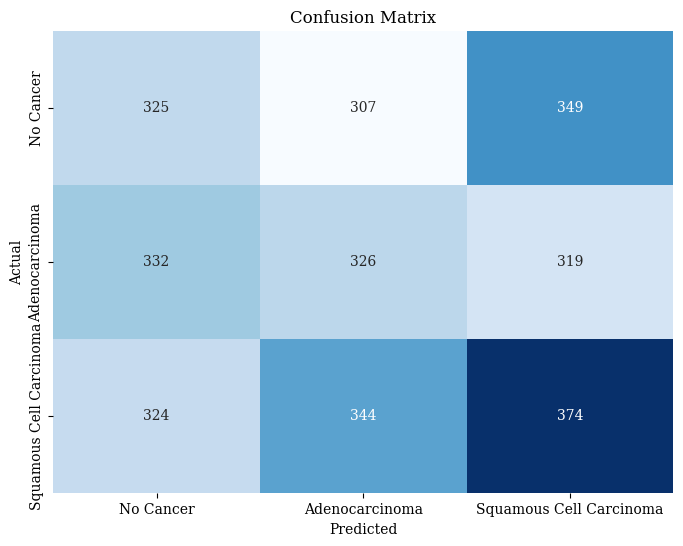

Classification Report:
                         precision    recall  f1-score   support

              No Cancer       0.33      0.33      0.33       981
         Adenocarcinoma       0.33      0.33      0.33       977
Squamous Cell Carcinoma       0.36      0.36      0.36      1042

               accuracy                           0.34      3000
              macro avg       0.34      0.34      0.34      3000
           weighted avg       0.34      0.34      0.34      3000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to plot a confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Load test data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    subset="validation",
    validation_split=0.2
)

# Extract true labels from the test dataset
true_labels = []
for images, labels in test_ds:
    true_labels.extend(labels.numpy())

# Predict labels using your trained model
predicted_labels = efficientnet_model.predict(test_ds)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Plot the confusion matrix
plot_confusion_matrix(true_labels, predicted_labels, class_details)

# Calculate and display classification report
report = classification_report(true_labels, predicted_labels, target_names=class_details)
print("Classification Report:")
print(report)

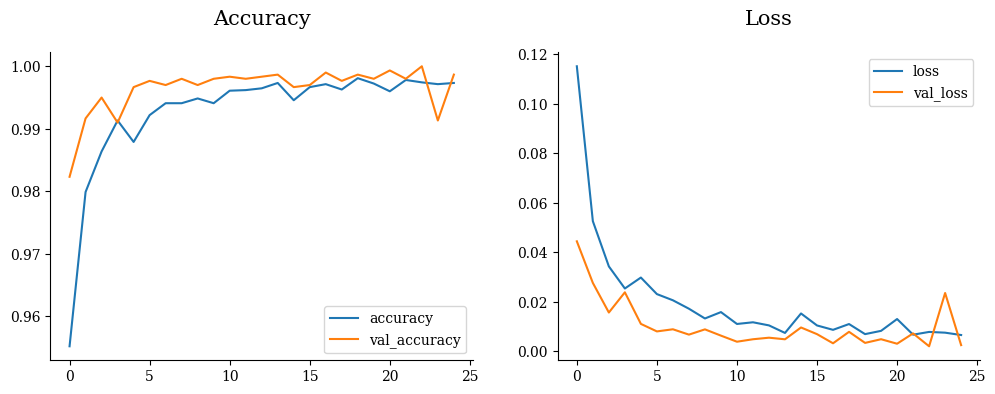

In [ ]:
performance_df = pd.DataFrame(efficientnet_history.history)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for ax, metric in zip(axes.flat, ["accuracy", "loss"]):
    performance_df.filter(like=metric).plot(ax=ax)
    ax.set_title(metric.title(), size=15, pad=20)


In [ ]:
#save the model
efficientnet_model.save_weights("efficientnet_model_weights.h5")
loaded_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    prerained_efficientnet_base,  # Reuse the pretrained base
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])
loaded_model.load_weights("efficientnet_model_weights.h5")
loaded_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


1/1 [==============================] - 2s 2s/step


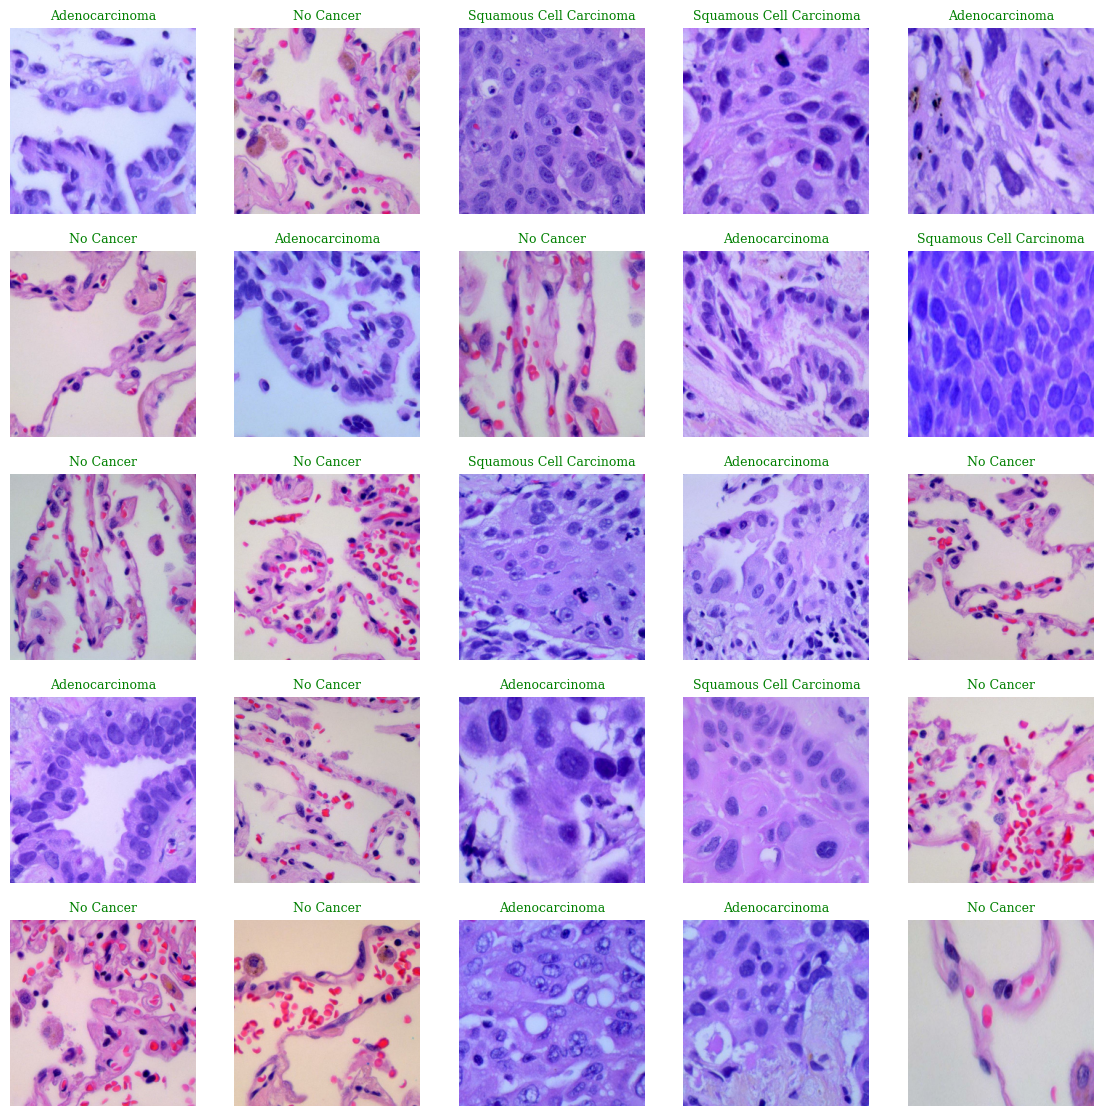

In [ ]:
# Visualize Sample Predictions: Showing some sample images along with their true and predicted labels to get a visual sense of how well the model is performing.
def visualize_sample_predictions(model, dataset, class_details):
    plt.figure(figsize=(14, 14))
    for images, labels in dataset.take(1):
        labels = labels.numpy()
        predicted_labels = np.argmax(model.predict(images), axis=1)
        for i in range(len(labels)):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if labels[i] == predicted_labels[i]:
                plt.title(class_details[labels[i]], color="green", size=9)
            else:
                plt.title(f"{class_details[predicted_labels[i]]}\n"
                          + f"(Actual: {class_details[labels[i]]})",
                          color="red", size=9)
            plt.axis("off")

# Visualize sample predictions on the validation dataset
visualize_sample_predictions(efficientnet_model, validation_ds, class_details)
